<a href="https://colab.research.google.com/github/big-muzzy/Segmentation/blob/master/UNet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing.image import img_to_array, load_img # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

Собственная функция метрики, обрабатывающая пересечение двух областей

In [2]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [3]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!mkdir data
!cp "/content/drive/My Drive/Colab files/lesson14/dataset1.zip" "/content/data"

In [ ]:
!unzip data/dataset1.zip -d data

#Загружаем картинки

In [6]:
# Создаем пустой список для хранений оригинльных изображений обучающей выборки
images = []                                 

# Указываем путь к обучающей выборке с оригинальными изображения
directory = '/content/data/dataset1/images_prepped_train' 

# Проходим по всем файлам в каталоге по указанному пути 
for filename in os.listdir(directory):
  
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    images.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(352, 480))).astype('uint8'))

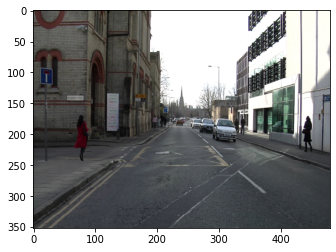

In [7]:
# Отобразим произвольную картинку
plt.imshow(images[0])
plt.show()

In [8]:
# Создаем пустой список для хранений оригинльных изображений тестовой выборки
imagesTest = [] 

# Указываем путь к тестовой выборке с оригинальными изображения
directory = '/content/data/dataset1/images_prepped_test' 

# Проходим по всем файлам в каталоге по указанному пути 
for filename in os.listdir(directory): 
  
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size
    imagesTest.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(352, 480))).astype('uint8')) 


In [9]:
# Создаем пустой список для хранения карт сегментации обучающей выборки
segments = [] 

# Указываем путь к каталогу с картами сегментации, соотвествующим оригинальным изображениям
directory = '/content/data/dataset1/annotations_prepped_train'

# Пробегаем по всем файлам в каталоге по указанному пути
for filename in os.listdir(directory): 
  
    # Читаем очередную картинку и добавляем ее в список карт сегментации с указанным target_size
    segments.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(352, 480))).astype('uint8')[:,:,0]) 


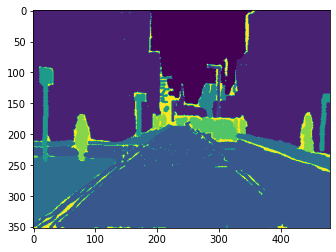

In [10]:
# Отобразим произвольную карту сегментации
plt.imshow(segments[0])
plt.show()

In [11]:
# Создаем пустой список для хранения карт сегментации тестовой выборки
segmentsTest = [] 

# Указываем путь к каталогу с картами сегментации, соотвествующим оригинальным изображениям тестовой выборки
directory = '/content/data/dataset1/annotations_prepped_test' 

# Пробегаем по всем файлам в каталоге по указанному пути
for filename in os.listdir(directory): 
  
    # Читаем очередную картинку и добавляем ее в список карт сегментации с указанным target_size
    segmentsTest.append(img_to_array(load_img(os.path.join(directory,filename), target_size=(352, 480))).astype('uint8')[:,:,0])


#Создаём обучающую выборку

Для тренировочной выборки картинок полного размера

In [12]:
xTrainFull = np.array(images) # Переводим в numpy

In [13]:
yTrainFull = np.array(segments)[:,:,:,None] # Переводим в numpy

# **Создаем проверочную выборку**

Для тестовой выборки картинок полного размера

In [14]:
xTestFull = np.array(imagesTest) # Переводим в numpy

yTestFull = np.array(segmentsTest)[:,:,:,None] # Переводим в numpy

print(xTestFull.shape)          # Отображаем размерность xTest
print(yTestFull.shape)          # Отображаем размерность yTest

(101, 352, 480, 3)
(101, 352, 480, 1)


# **Посмотрим разметку**

Изначально разметка выполнена не идеально. Укрупним данные.

In [15]:
yTrainFull_org = yTrainFull.copy()
yTrainFull = np.zeros_like(yTrainFull_org)
yTrainFull = np.where(np.isin(yTrainFull_org, [4]), 5, yTrainFull)
yTrainFull = np.where(np.isin(yTrainFull_org, [0]), 0, yTrainFull)
yTrainFull = np.where(np.isin(yTrainFull_org, [3]), 1, yTrainFull)
yTrainFull = np.where(np.isin(yTrainFull_org, [9, 10]), 2, yTrainFull)
yTrainFull = np.where(np.isin(yTrainFull_org, [8]), 3, yTrainFull)
yTrainFull = np.where(np.isin(yTrainFull_org, [1, 2, 5, 6, 7, 11]), 4, yTrainFull)


In [16]:
yTestFull_org = yTestFull.copy()
yTestFull = np.zeros_like(yTestFull_org)
yTestFull = np.where(np.isin(yTestFull_org, [4]), 5, yTestFull)
yTestFull = np.where(np.isin(yTestFull_org, [0]), 0, yTestFull)
yTestFull = np.where(np.isin(yTestFull_org, [3]), 1, yTestFull)
yTestFull = np.where(np.isin(yTestFull_org, [9, 10]), 2, yTestFull)
yTestFull = np.where(np.isin(yTestFull_org, [8]), 3, yTestFull)
yTestFull = np.where(np.isin(yTestFull_org, [1, 2, 5, 6, 7, 11]), 4, yTestFull)


[0 1 2 3 4 5]
mark: 0


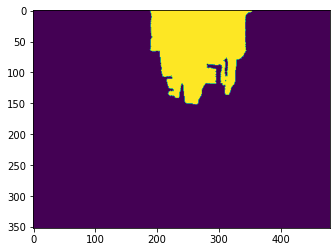

mark: 1


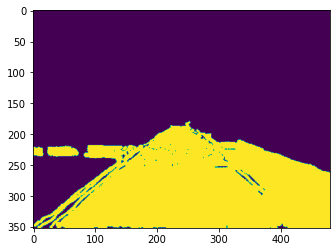

mark: 2


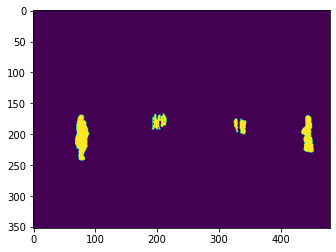

mark: 3


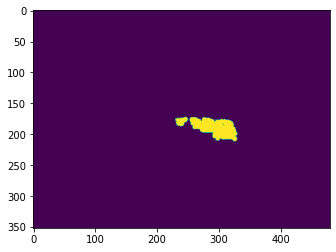

mark: 4


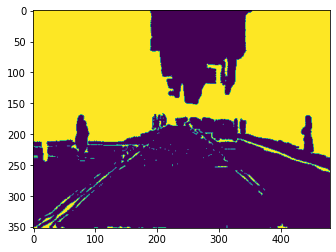

mark: 5


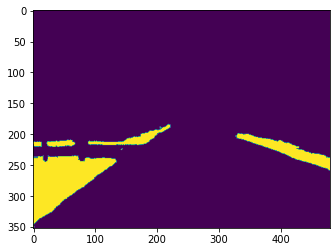

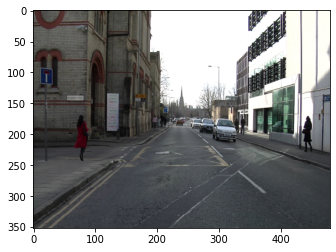

In [17]:
n = 0
print(np.unique(yTrainFull))

for mark in np.unique(yTrainFull):
  img = yTrainFull[n] == mark
  print("mark:", mark)
  plt.imshow(img.squeeze(-1))
  plt.show()

plt.imshow(xTrainFull[n])
plt.show()

* 0 - Небо (0)
* 1 - дорога (3)
* 2 - люди (9, 10)
* 3 - автомобили (8)
* 4 - стены, столбы и прочее (1, 2, 5, 6, 7, 11)
* 5 - тротуар (4)

**Преобразуем картинку сегментации в OHE**

Своя функция преобразования в OHE. Компиляция numba.

In [18]:
from numba import jit

In [19]:
@jit(nopython=True)
def mtxOneHot(mtx, numClasses):
  result = np.zeros((mtx.shape + (numClasses, )))
  for row in range(mtx.shape[0]):
    for col in range(mtx.shape[1]):
      result[row, col, mtx[row, col]] = 1
  return result

def batchOneHot(batch, numClasses):
  result = []
  for item in range(len(batch)):
    tmp = mtxOneHot(batch[item].squeeze(-1), numClasses)
    result.append(tmp)
  result = np.array(result)
  return result


**Превращаем сегментированную картинку в One hot encoding**

In [20]:
import time

In [21]:
start = time.time()
numClasses = yTrainFull.max() + 1  
yTrain = batchOneHot(yTrainFull, numClasses) # Получаем OHE-выборку
yTest = batchOneHot(yTestFull, numClasses)   # Получаем OHE-выборку 
print(time.time()- start)


5.073155641555786


In [22]:
print(xTrainFull.shape)   # Отобразим размерность xTrain
print(yTrain.shape) # Отобразим размерность yTrain12

(367, 352, 480, 3)
(367, 352, 480, 6)


#Создаём и обучаем U-net

In [23]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [24]:
model = unet(yTrain.shape[-1], xTrainFull.shape[1:])                                                              # Создаем модель unet
history = model.fit(xTrainFull, yTrain, epochs=30, batch_size=8, validation_data = (xTestFull, yTest), verbose=0) # Обучаем модель

#Распознаём обучающую выборку

In [25]:
pred = model.predict(xTestFull) # Предиктим тестовую выборку
print(pred.shape) # Отобразим размерность pred

(101, 352, 480, 6)


In [26]:
out = pred.argmax(-1) # Получаем расскрашенные распознанные изображения

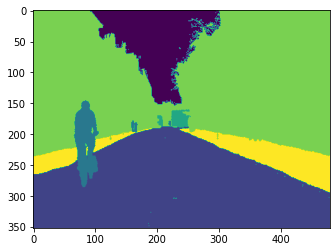

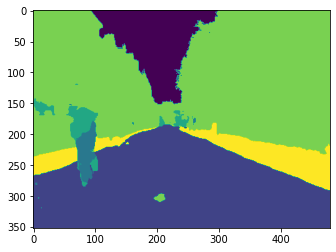

In [27]:
n = 2 # Укажем номер произвольного изображения

# Отобразим оригинальную карту сегментации 
img = yTestFull[n].squeeze(-1)
plt.imshow(img)
plt.show()

# Отобразим распознанную карту
img = out[n]
plt.imshow(img)
plt.show()

Дообучим сеть с меньшим шагом.

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

In [29]:
history = model.fit(xTrainFull, yTrain, epochs=30, batch_size=8, validation_data = (xTestFull, yTest), verbose=0) # Обучаем модель

(101, 352, 480, 6)


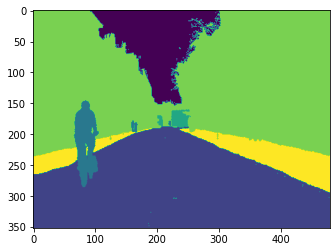

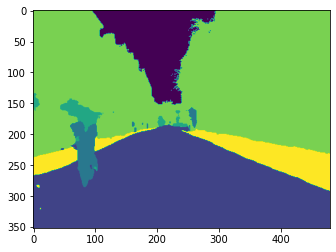

In [30]:
pred = model.predict(xTestFull) # Предиктим тестовую выборку
print(pred.shape) # Отобразим размерность pred
out = pred.argmax(-1) # Получаем расскрашенные распознанные изображения
n = 2 # Укажем номер произвольного изображения

# Отобразим оригинальную карту сегментации
img = yTestFull[n].squeeze(-1)
plt.imshow(img)
plt.show()

# Отобразим распознанную карту
img = out[n]
plt.imshow(img)
plt.show()